# PPC

die methode heißt posterior predictive checking - sprich man nimmt parameter aus der posterior distribution und simuliert damit dann daten. ist an sich eine methode zum model checking. Ich machs zum Beispiel um zu checken ob unsere Hintergrundmodell für GBM fähig ist, die Lichtkurve zu erklären.

Das Beispiel ist jetzt im Falle von nem GRB und wichtig ich falte hier gerade nicht durch die Response, sondern erzeug nur nen Plot in dem man das 95% confidence band sieht


Mehr zu PPC findest du in Björns PhD thesis

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/tguethle/Documents/spi/Master_Thesis/main_files'))


import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
from astromodels import Powerlaw, PointSource, SpectralComponent
import astropy.time as at
from datetime import datetime
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum, MultinestClusterFit
from RebinningFunctions import spimodfit_binning_SE, log_binning_function_for_x_number_of_bins, no_rebinning #, rebin_data_exp_50
from PointingClusters import PointingClusters, save_clusters, load_clusters
from ModelSources import *
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
from chainconsumer import ChainConsumer

18:26:03 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=256458;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=199684;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=344989;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=867922;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=801289;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=742368;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

18:26:04 INFO      Starting 3ML!                                                                     ]8;id=158750;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=8436;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#31\31]8;;\

18:26:05 WARNING   ROOT minimizer not available                                                ]8;id=427941;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=319700;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

18:26:06 WARNING   PyGMO is not available                                                      ]8;id=359848;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=985550;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

18:26:06 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=468228;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=506170;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#79\79]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=895659;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=576975;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=78304;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=30812;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=775945;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=241119;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

Using the irfs that are valid between Start and 03/07/06 06:00:00 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 03/07/06 06:00:00 and 04/07/17 08:20:06 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 09/02/19 09:59:57 and 10/05/27 12:45:00 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)


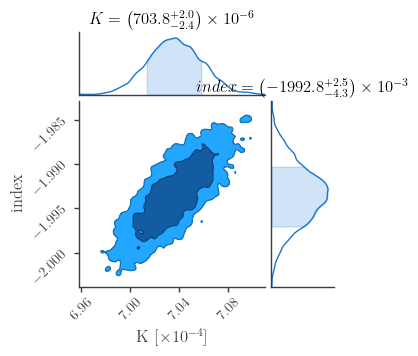

In [3]:
chain = np.loadtxt("1-post_equal_weights.dat")
c = ChainConsumer()
c.add_chain(chain[:,:-1],parameters=["K","index"],posterior=chain[:,-1])
c.plotter.plot()

def cpl(E, k,i,xc):
    return k*np.power(E,i)*np.exp(-(E/xc))

In [4]:
chain.shape

(2817, 3)

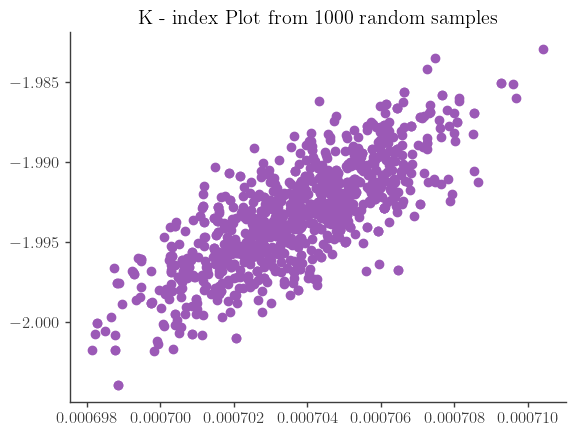

In [5]:
# ich zieh mir 1000 samples aus der posterior distribution - vergleichs obs ähnlich zum corner plot ist
nsamples = 1000
rnd_samples = np.random.randint(len(chain[:,0]),size = nsamples)
plt.title(f"K - index Plot from {nsamples} random samples")
plt.scatter(chain[rnd_samples,0],chain[rnd_samples,1])

In [36]:
# define constants for the response folding. all with the band model
pointing_id = 0
emod = np.geomspace(20, 1000, 100)
ra, dec = 10, -40
orig_data_path = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center'


# load the data from the base data files
# Energy Bins
with fits.open(f"{orig_data_path}/energy_boundaries.fits") as file:

    t = Table.read(file[1])
    energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    print(f'Number of energy bins: {len(energy_bins)-1}')
# Pointings and Start Times
with fits.open(f"{orig_data_path}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


# Time Elapsed
# det=i, pointing_index=j : index = j*85 + i
with fits.open(f"{orig_data_path}/dead_time.fits") as file:
    
    t = Table.read(file[1])
    time_elapsed = np.array(t["LIVETIME"])

# Generate Source Counts

assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
version = find_response_version(time_start[0])
rsp_base = ResponseDataRMF.from_version(version)

time = time_start[pointing_id]
dets = get_live_dets(time=time, event_types=["single"])

rmfs = []
for d in dets:
    rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))
    
sds = np.empty(0)
for d in range(len(dets)):
    sd = SPIDRM(rmfs[d], ra, dec)
    sds = np.append(sds, sd.matrix.T)
resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))

# all above is the same for one single pointing. the only thing that changes are the parameters


def fold_respose(parameter, piv=100):
    K, index_pl = parameter
    # define the source
    pl = Powerlaw()
    pl.piv = piv
    pl.K = K
    pl.index = index_pl
    component1 = SpectralComponent("pl", shape=pl)
    source = PointSource("Test", ra=ra, dec=dec, components=[component1])

    spec_binned = powerlaw_binned_spectrum(emod, source(emod))

    count_rates = np.dot(spec_binned, resp_mat)
    source_counts_poisson = np.zeros((19, len(energy_bins)-1), dtype=np.uint32)
    source_counts = np.zeros((19, len(energy_bins)-1), dtype=np.uint32)

    for d_i, d in enumerate(dets):
        index = pointing_id * 85 + d
        source_counts[d] = count_rates[d_i,:] * time_elapsed[index]
        source_counts_poisson[d] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])

    return source_counts, source_counts_poisson




Number of energy bins: 41
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)


In [37]:
chain.shape

(2817, 3)

In [38]:
# ich falte das jetzt nicht durch die response sondern lass mir nur die functions werte ausgeben

e = np.geomspace(3,5000,1000)


vals = np.zeros((nsamples,19,len(energy_bins)-1))
for n, rnd_sample in enumerate(rnd_samples):
    # hier müsstest dus dann durch die response falten, sprich zwischen den input energies integrieren und mit der response multiplizieren

    vals[n] = fold_respose(chain[rnd_sample,:2])[1]
    print(f"Sample {n}/1000 done")


Sample 0/1000 done
Sample 1/1000 done
Sample 2/1000 done
Sample 3/1000 done
Sample 4/1000 done
Sample 5/1000 done
Sample 6/1000 done
Sample 7/1000 done
Sample 8/1000 done
Sample 9/1000 done
Sample 10/1000 done
Sample 11/1000 done
Sample 12/1000 done
Sample 13/1000 done
Sample 14/1000 done
Sample 15/1000 done
Sample 16/1000 done
Sample 17/1000 done
Sample 18/1000 done
Sample 19/1000 done
Sample 20/1000 done
Sample 21/1000 done
Sample 22/1000 done
Sample 23/1000 done
Sample 24/1000 done
Sample 25/1000 done
Sample 26/1000 done
Sample 27/1000 done
Sample 28/1000 done
Sample 29/1000 done
Sample 30/1000 done
Sample 31/1000 done
Sample 32/1000 done
Sample 33/1000 done
Sample 34/1000 done
Sample 35/1000 done
Sample 36/1000 done
Sample 37/1000 done
Sample 38/1000 done
Sample 39/1000 done
Sample 40/1000 done
Sample 41/1000 done
Sample 42/1000 done
Sample 43/1000 done
Sample 44/1000 done
Sample 45/1000 done
Sample 46/1000 done
Sample 47/1000 done
Sample 48/1000 done
Sample 49/1000 done
Sample 50/

In [39]:

vals[0,:,0]

array([31.,  9.,  0., 27., 31., 29., 33.,  3., 12.,  8., 14.,  8., 24.,
       27., 11., 18., 25.,  0.,  7.])

In [44]:
# das sind ist das 95% interval
min_val = np.percentile(vals, 2.5, axis=0)
max_val = np.percentile(vals, 97.5, axis=0)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


WARNING RuntimeWarning: invalid value encountered in true_divide



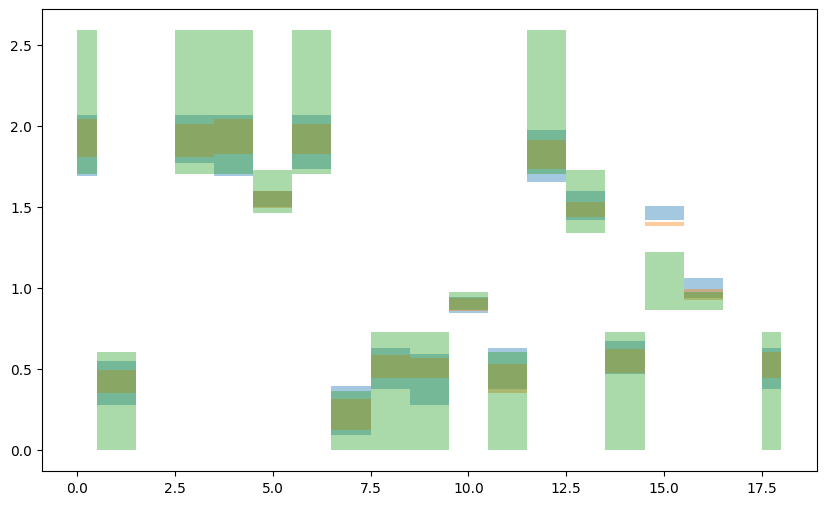

In [45]:
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(10,6))

min_val_normal, max_val_normal = min_val / np.nanmean(min_val, axis=0), max_val / np.nanmean(max_val, axis=0)

x_det = np.arange(0,19)

used_bins = (0,10,40)

for bin in used_bins:
    ax.fill_between(x_det, min_val_normal[:,bin], max_val_normal[:,bin], alpha=0.4, step="mid", label=f"Energy Bin {bin}")
    # ax.step(x_det, min_val_normal[:,bin], where="mid", alpha=0.99)
    # ax.step(x_det, max_val_normal[:,bin], where="mid", alpha=0.99, linestyle="--")


In [32]:
print(min_val_normal[:,0])
print(max_val_normal[:,0])

print(min_val[:,0])
print(max_val[:,0])

[1.81583316 0.47537808 0.         1.86286244 1.87541218 1.52967474
 1.82884162 0.29300434 0.51031822 0.4931288  0.90446354 0.51961073
 1.78750432 1.46344178 0.60036656 1.46180372 1.00770034 0.
 0.57065543]
[1.81593354 0.47528709 0.         1.8628998  1.87559891 1.52958026
 1.82893571 0.2929725  0.51042552 0.49293446 0.90471608 0.51949689
 1.7877377  1.46359598 0.60012617 1.46192781 1.00713565 0.
 0.57069594]
[31.64366225  8.28418802  0.         32.4632193  32.68191767 26.65691534
 31.87035457  5.10604748  8.89307323  8.5935215  15.76165663  9.05500941
 31.14998906 25.50270506 10.46230296 25.47415928 17.56071543  0.
  9.94454131]
[32.17091875  8.42014424  0.         33.00296885 33.22794516 27.09790919
 32.40126402  5.19027499  9.04265359  8.73278341 16.02787044  9.20336108
 31.67140367 25.92893743 10.63178232 25.89938441 17.84232651  0.
 10.11039895]


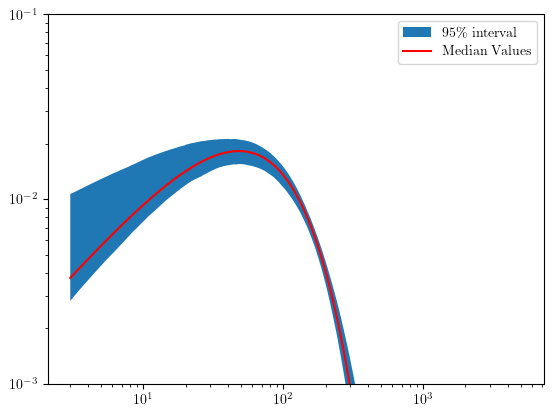

In [6]:
plt.fill_between(e,min_val,max_val,label = "95\% interval")
plt.plot(e,cpl(e,np.median(ks),np.median(indices),np.median(xcs)),color = "red",label = "Median Values")
plt.legend()
plt.ylim(10e-4,10e-2)
plt.xscale("log")
plt.yscale("log")